In [1]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF

In [2]:
# Use this if you are using any Cuda enabled system
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
class CamVidDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        label_path = os.path.join(self.label_dir, self.images[index].replace('.png', '_L.png'))
        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path)
        # label = Image.open(label_path).convert("L")
        if self.transform is not None:
            image = self.transform(image)
            label = self.transform(label)
        return image, label

In [4]:
# Define transforms if necessary
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Assuming you have your dataset in 'CamVid/images' and 'CamVid/labels'
image_dir = 'CamVid/train'
label_dir = 'CamVid/train_labels'

dataset = CamVidDataset(image_dir, label_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(
    #    self, in_channel=3, out_channel=3, features=[64, 128, 256, 512],
       self, in_channel=3, out_channel=3, features=[32, 64, 128, 256],
    ): 
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling
        for feature in features:
            self.downs.append(DoubleConv(in_channel, feature))
            in_channel = feature
        
        # Upsampling
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))
        
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channel, 1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x =self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [6]:
class Reshape(nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

class Autoencoder(nn.Module):
    def __init__(self, latent_dim,hidden_dim,input_dim):
        super(Autoencoder, self).__init__()
        output_dim = input_dim
        #TODO
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim,latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(),
            Reshape(-1, 3, 720, 960)
        )

    def forward(self, x):
        #TODO
        x = self.encoder(x)
        x = self.decoder(x)
        # x = x.view(-1, 1, 28, 28)

        return x

In [7]:
class DenoiseAE(nn.Module):
    def __init__(self):
        super(DenoiseAE, self).__init__()
        #TODO
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8,kernel_size=3,padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=8, out_channels=16,kernel_size=4,padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=16, out_channels=32,kernel_size=8,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16,kernel_size=2,stride=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels=16, out_channels=8,kernel_size=6,stride=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(in_channels=8, out_channels=3,kernel_size=2,stride=1),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2),

            nn.Sigmoid(),
            Reshape(-1, 3, 720, 960)
        )
    
    def forward(self,x):
        #TODO
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
model = UNet(in_channel=3, out_channel=3).to(device)

# hidden_dim = 64
# latent_dim = 2
# batch_size = 64
# model = Autoencoder(latent_dim, hidden_dim, 3*720*960).to(device)
# model = DenoiseAE().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(inputs.shape)
        # print(labels.shape)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/10, Loss: 1.0078063011169434
Epoch 2/10, Loss: 0.8279611468315125
Epoch 3/10, Loss: 0.7416658997535706
Epoch 4/10, Loss: 0.9623449444770813
Epoch 5/10, Loss: 0.8859370350837708
Epoch 6/10, Loss: 0.9079445004463196
Epoch 7/10, Loss: 1.146523118019104
Epoch 8/10, Loss: 0.74253910779953
Epoch 9/10, Loss: 0.7523590326309204
Epoch 10/10, Loss: 0.7899723052978516


In [9]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def plot_example(dataset, model, device, index=0):
    # Ensure the model is in eval mode
    model.eval()
    
    # Get an example from the dataset
    original_image, label = dataset[index]
    original_image = original_image.unsqueeze(0)  # Add batch dimension if needed
    
    # Move image to the device where the model is
    original_image = original_image.to(device)
    
    with torch.no_grad():  # Inference without tracking gradients
        prediction = model(original_image)
    
    # Assuming the prediction and label are class indices, you might need to convert them to color maps.
    # This step depends on your specific implementation and how your data is formatted.
    
    # Convert images to numpy for plotting (adjust as necessary)
    original_image_np = original_image.squeeze().cpu().numpy().transpose(1, 2, 0)
    prediction_np = prediction.squeeze().cpu().numpy()  # Adjust based on your prediction format
    label_np = label.cpu().numpy()  # Adjust based on your label format
    
    print(original_image_np.shape)
    print(prediction_np.shape)
    print(label_np.shape)
    prediction_np = prediction_np.transpose(1, 2, 0)
    label_np = label_np.transpose(1, 2, 0)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(prediction_np)
    axes[1].set_title('Model Prediction')
    axes[1].axis('off')
    
    axes[2].imshow(label_np)
    axes[2].set_title('Label Image')
    axes[2].axis('off')
    
    plt.show()

# Example usage:
# Assuming `dataset` is an instance of `CamVidDataset` and `model` is your trained model.
# plot_example(dataset, model, device='cuda', index=0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(720, 960, 3)
(3, 720, 960)
(3, 720, 960)


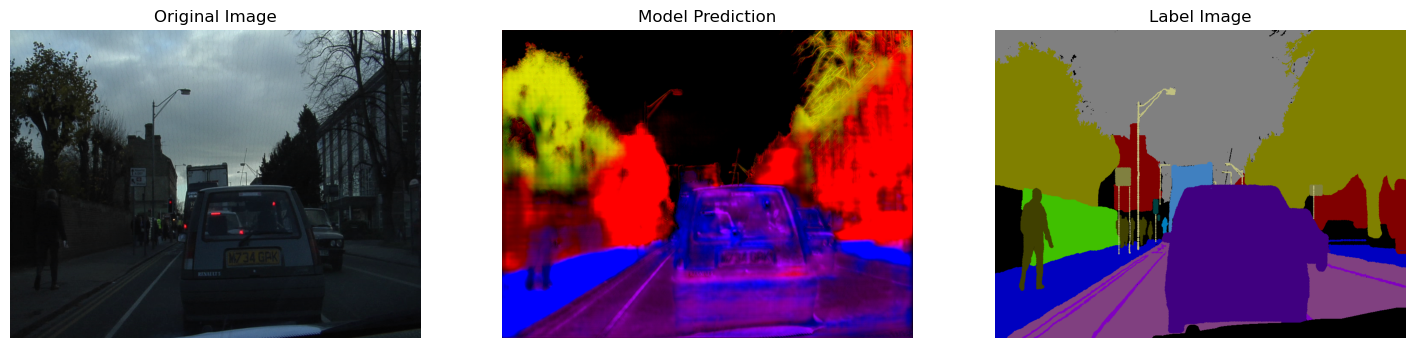

In [10]:
plot_example(dataset, model, device, 0)